In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST
dataset_root = "./data/fashion_pt" 
Dataset = FashionMNIST

## Data

In [3]:
transform = transforms.ToTensor()
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = Dataset(dataset_root, download=True, train=True, transform=transform)
testset = Dataset(dataset_root, download=True, train=False, transform=transform)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(classes)

### Data loader

In [4]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

idx = np.random.choice(batch_size)
print(labels.min(), labels.max(), len(labels))

tensor(0) tensor(9) 16


### Images examples

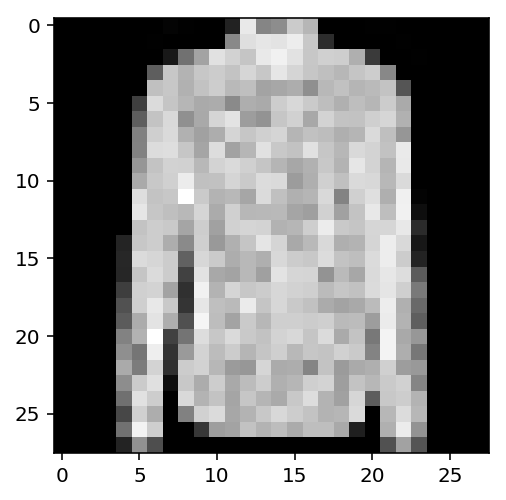

In [8]:
plt.imshow(np.squeeze(images[idx]), cmap='gray')

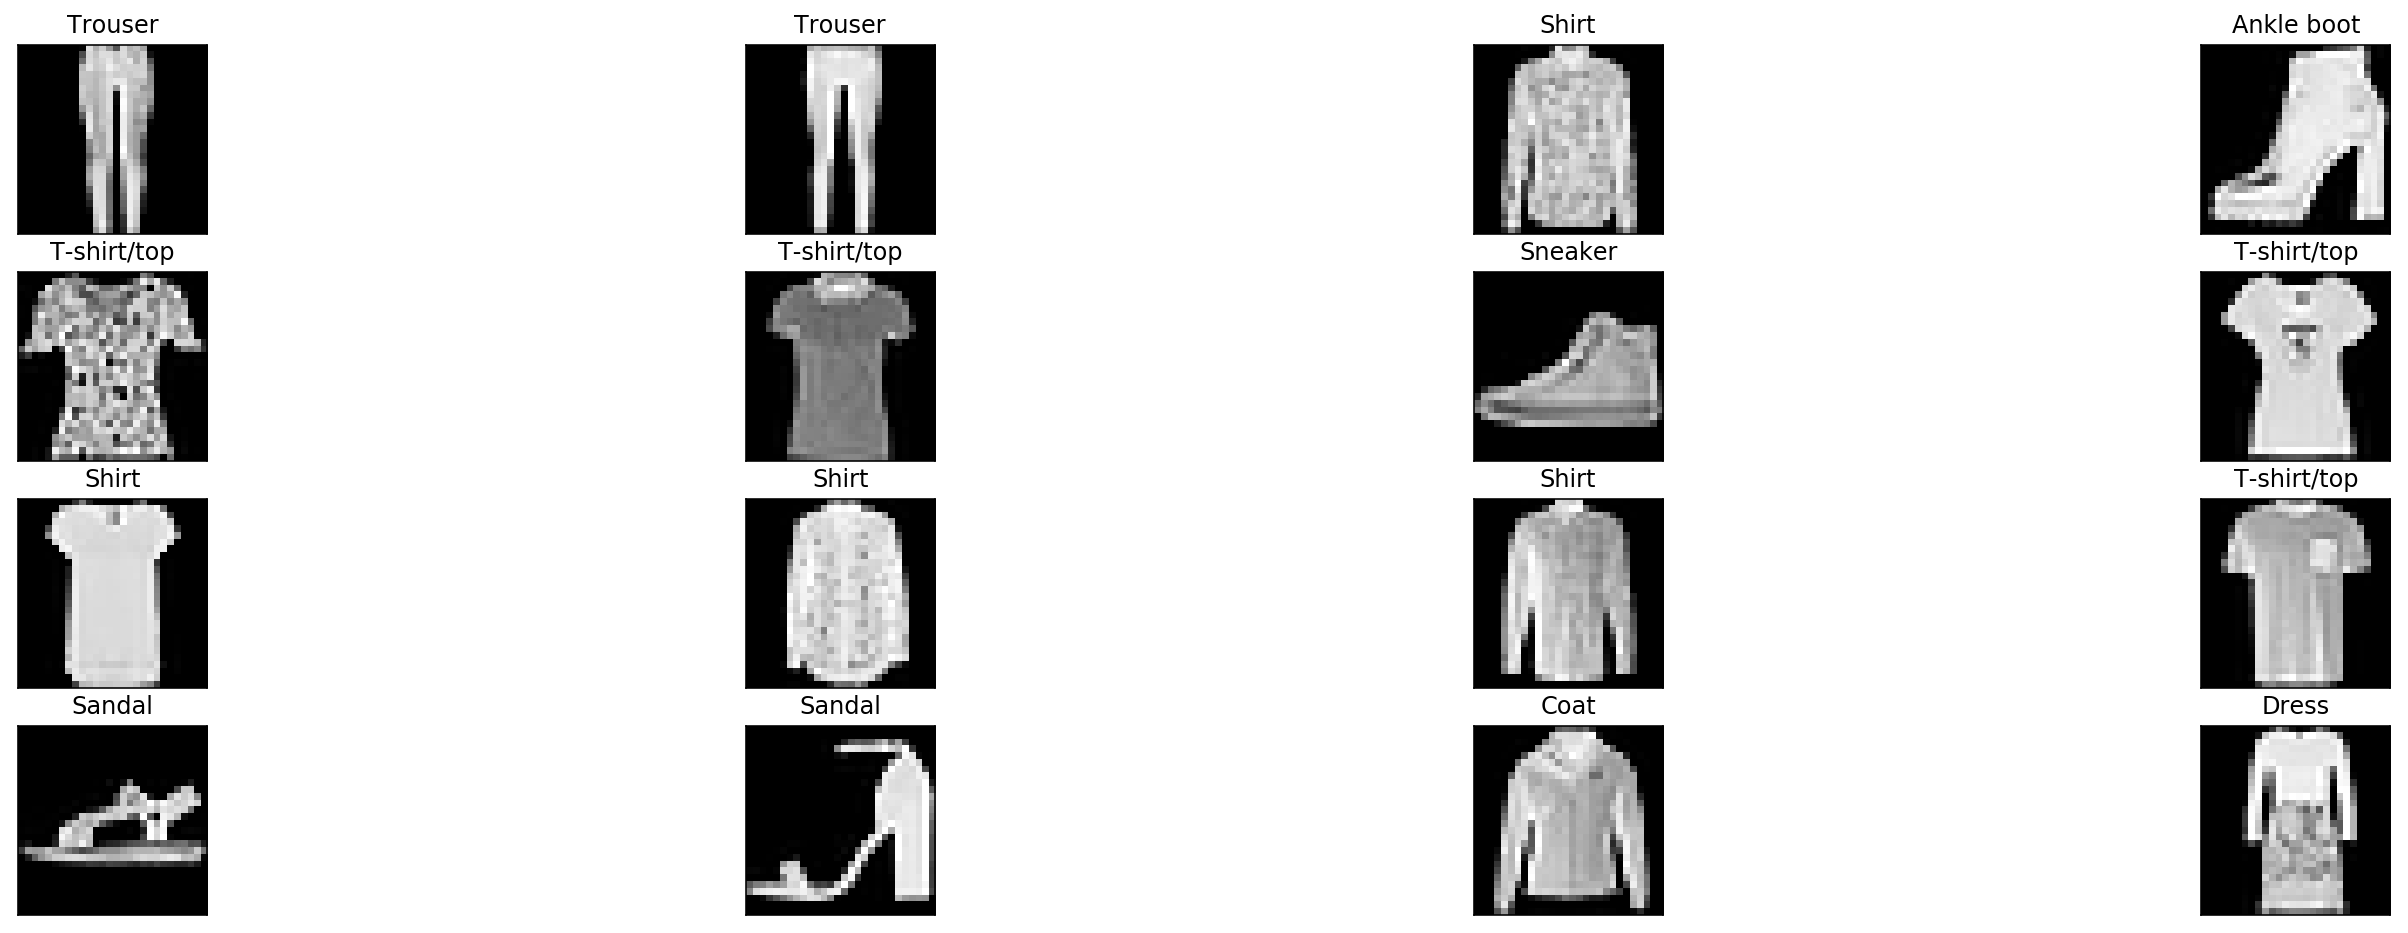

In [9]:
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

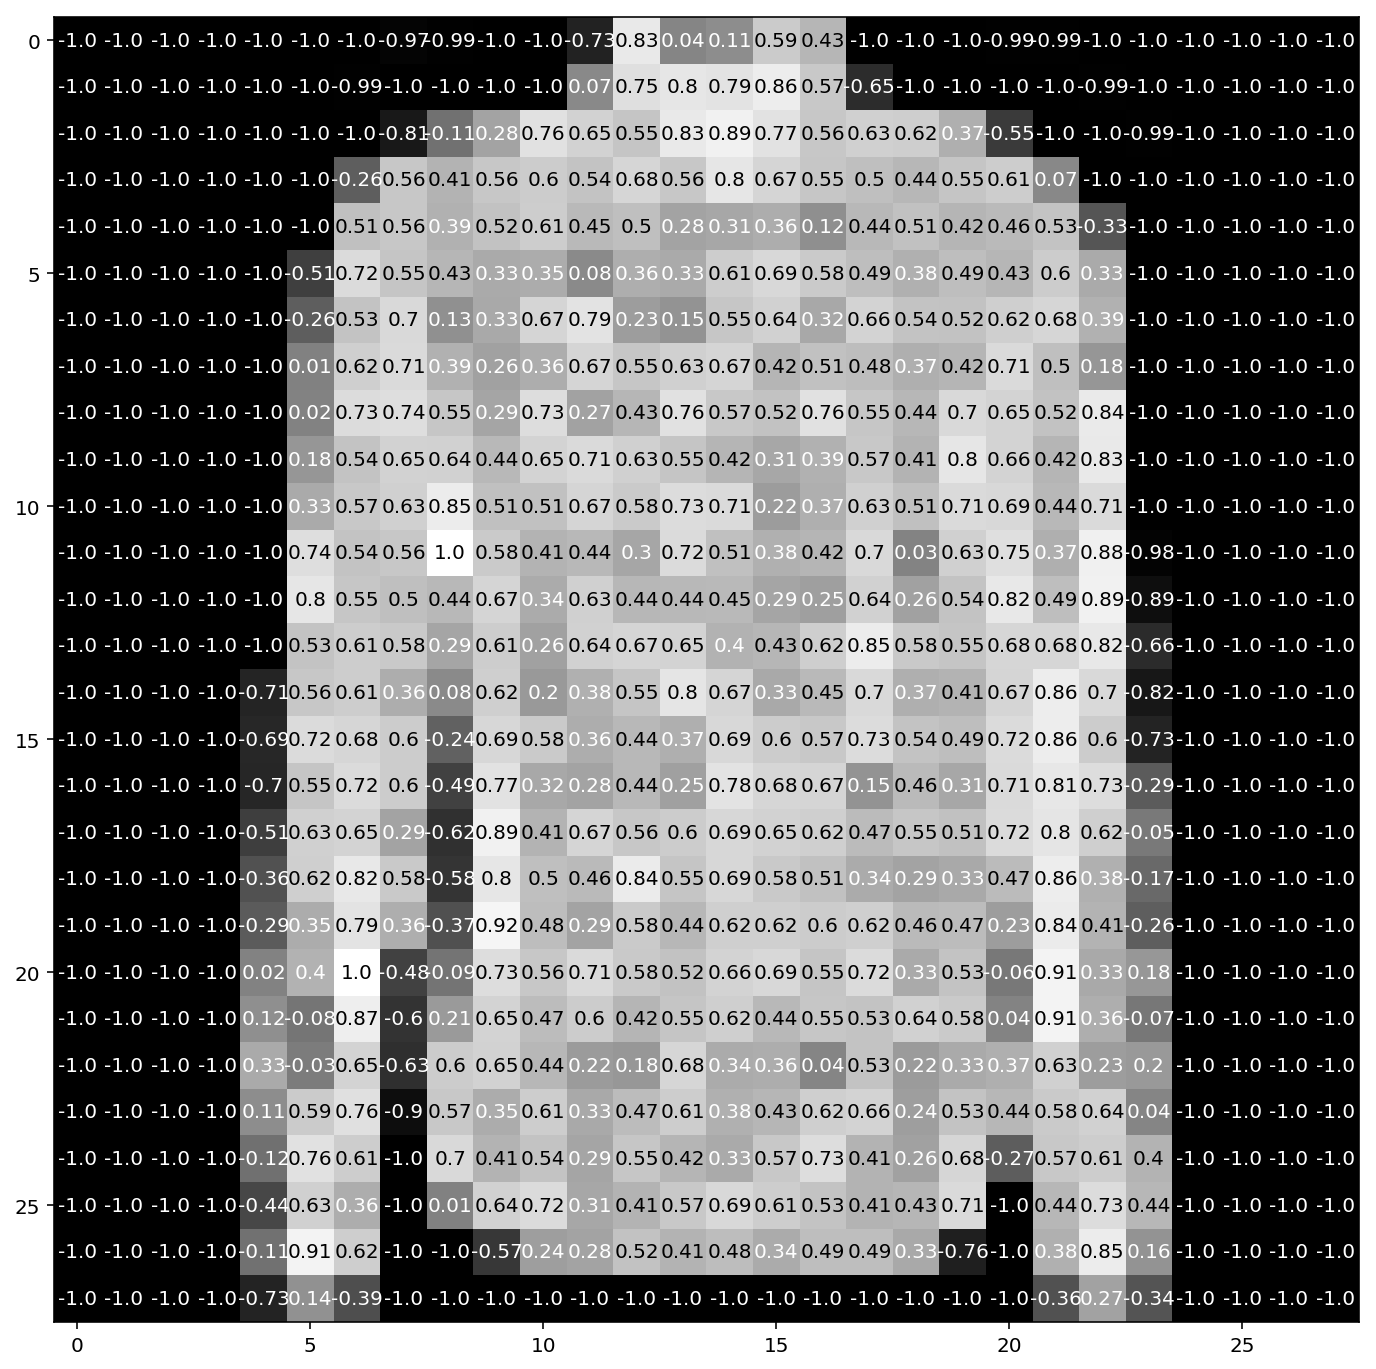

In [10]:
idx = np.random.choice(batch_size)
img = np.squeeze(images[idx])
# display the pixel values in that image
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## pytorch

In [11]:
from torch import nn
from torch import optim
import torch.nn.functional as F

In [25]:
input_dim = 28 * 28

class LinearNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(input_dim, 10)
        
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x
        
model = LinearNN()
model

LinearNN(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

In [26]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [28]:
correct = 0
total = 0

for images, labels in test_loader:

    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

accuracy = 100.0 * correct.item() / total

print(accuracy,"%")

9.93 %


In [29]:
def train(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = model(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time


In [30]:
n_epochs = 2 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 0.6199827650710941
Epoch: 1, Batch: 2000, Avg. Loss: 0.5046611131355166
Epoch: 1, Batch: 3000, Avg. Loss: 0.5022666653096676
Epoch: 2, Batch: 1000, Avg. Loss: 0.4647614686861634
Epoch: 2, Batch: 2000, Avg. Loss: 0.45567043862119316
Epoch: 2, Batch: 3000, Avg. Loss: 0.4559592682234943
Finished Training


In [33]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
model.eval()

all_labels
for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = model(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.487796

Test Accuracy of T-shirt/top: 72% (722/1000)
Test Accuracy of Trouser: 96% (967/1000)
Test Accuracy of Pullover: 79% (790/1000)
Test Accuracy of Dress: 86% (864/1000)
Test Accuracy of  Coat: 70% (702/1000)
Test Accuracy of Sandal: 84% (849/1000)
Test Accuracy of Shirt: 54% (547/1000)
Test Accuracy of Sneaker: 95% (953/1000)
Test Accuracy of   Bag: 93% (936/1000)
Test Accuracy of Ankle boot: 94% (944/1000)

Test Accuracy (Overall): 82% (8274/10000)


In [59]:
testset.test_data.shape

torch.Size([10000, 28, 28])

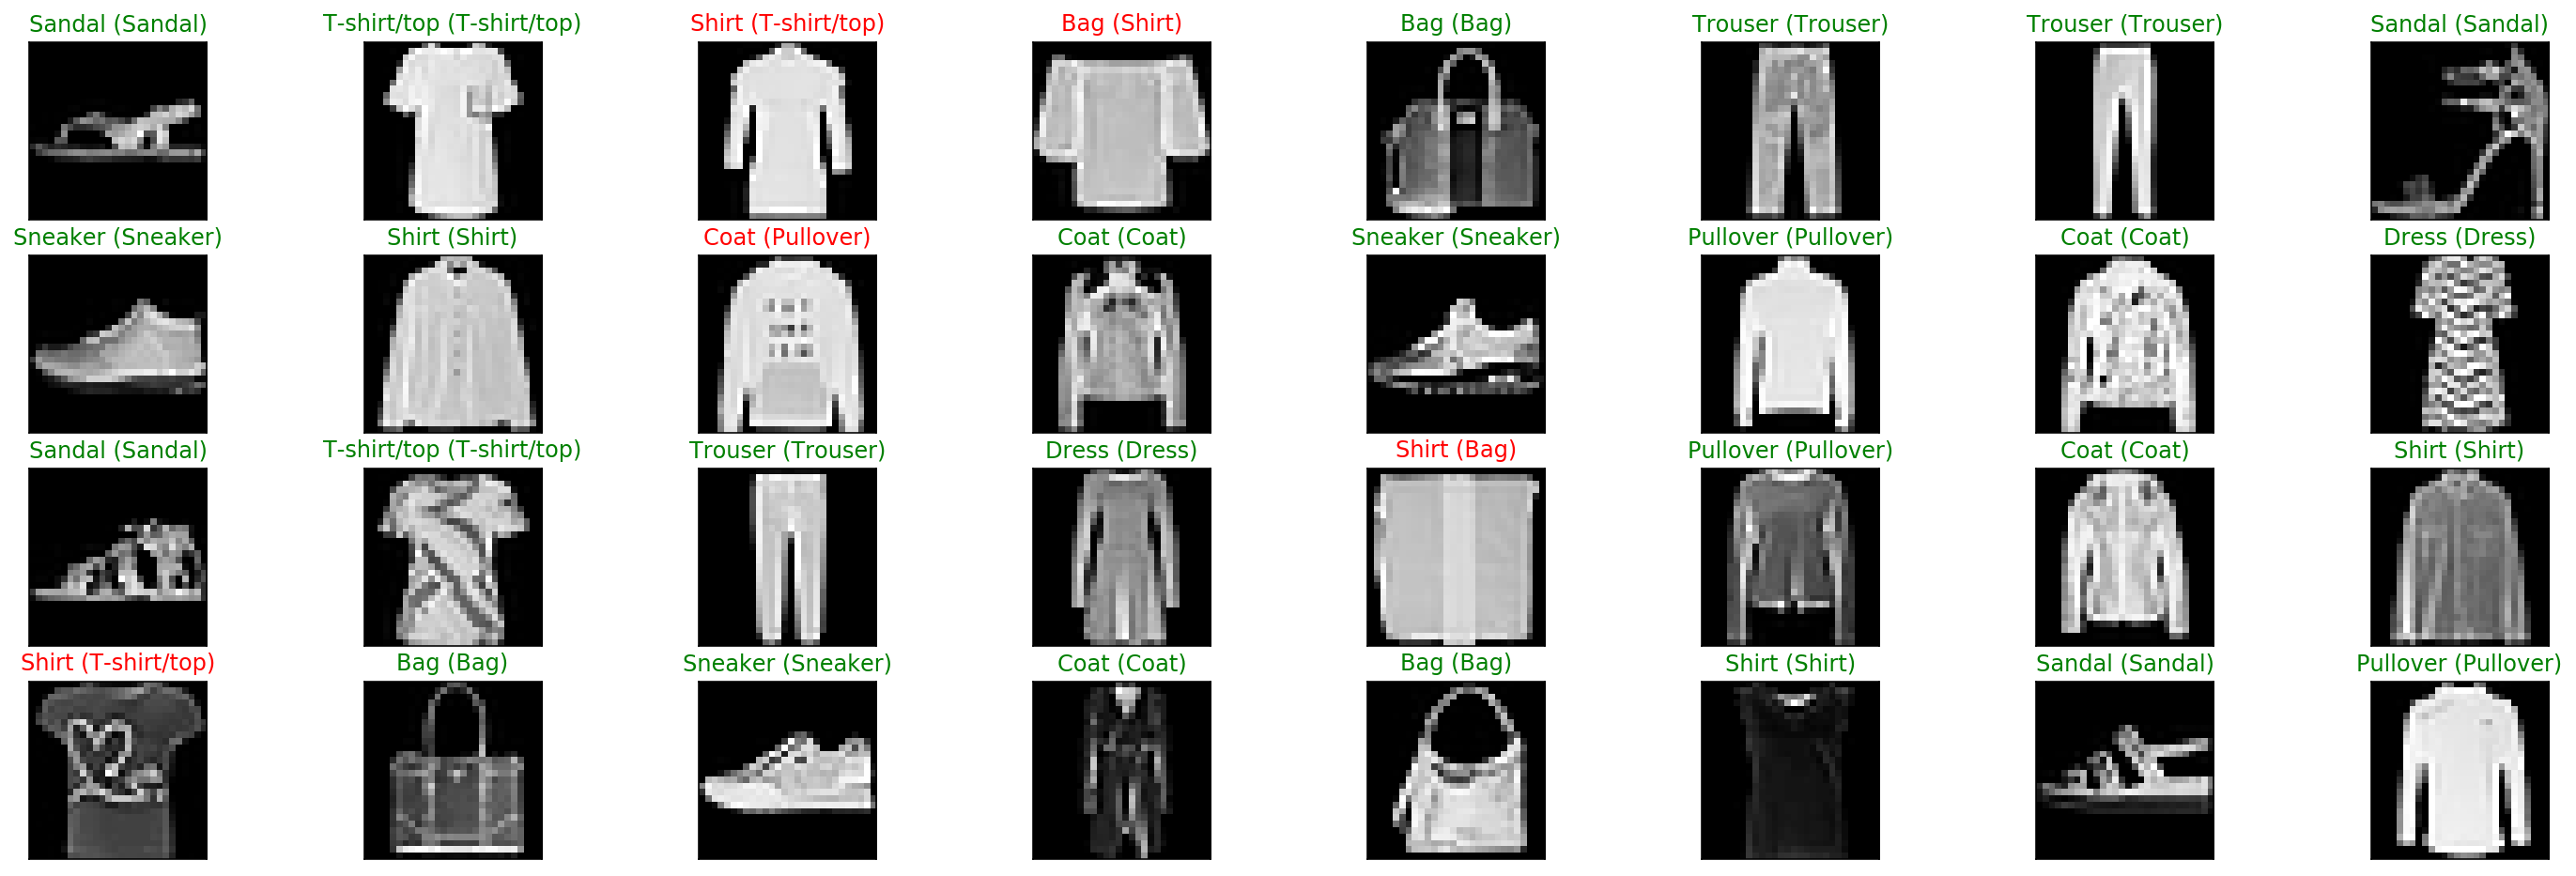

In [61]:
batch_size=32
test_loader2 = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

# obtain one batch of test images
dataiter = iter(test_loader2)
images, labels = dataiter.next()
# get predictions
outputs = model(images)
preds = np.squeeze(outputs.data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [66]:

batch_size=10000
test_loader3 = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=True)
dataiter = iter(test_loader3)
images, labels = dataiter.next()
outputs = model(images)
array  = confusion_matrix(labels, np.squeeze(outputs.data.max(1, keepdim=True)[1].numpy()))
array

array([[722,  12,  33,  79,   3,   1, 135,   1,  14,   0],
       [  0, 967,   3,  21,   4,   0,   4,   0,   1,   0],
       [ 13,   9, 790,  13,  93,   1,  72,   1,   8,   0],
       [ 12,  31,  27, 864,  29,   1,  28,   0,   8,   0],
       [  0,   3, 167,  32, 702,   0,  84,   0,  12,   0],
       [  0,   0,   0,   2,   0, 849,   0, 103,   5,  41],
       [ 95,   5, 177,  53,  96,   1, 547,   0,  26,   0],
       [  0,   0,   0,   0,   0,  12,   0, 953,   0,  35],
       [  1,   1,   7,  11,   2,   6,  25,  10, 936,   1],
       [  0,   0,   0,   0,   0,  10,   0,  45,   1, 944]])

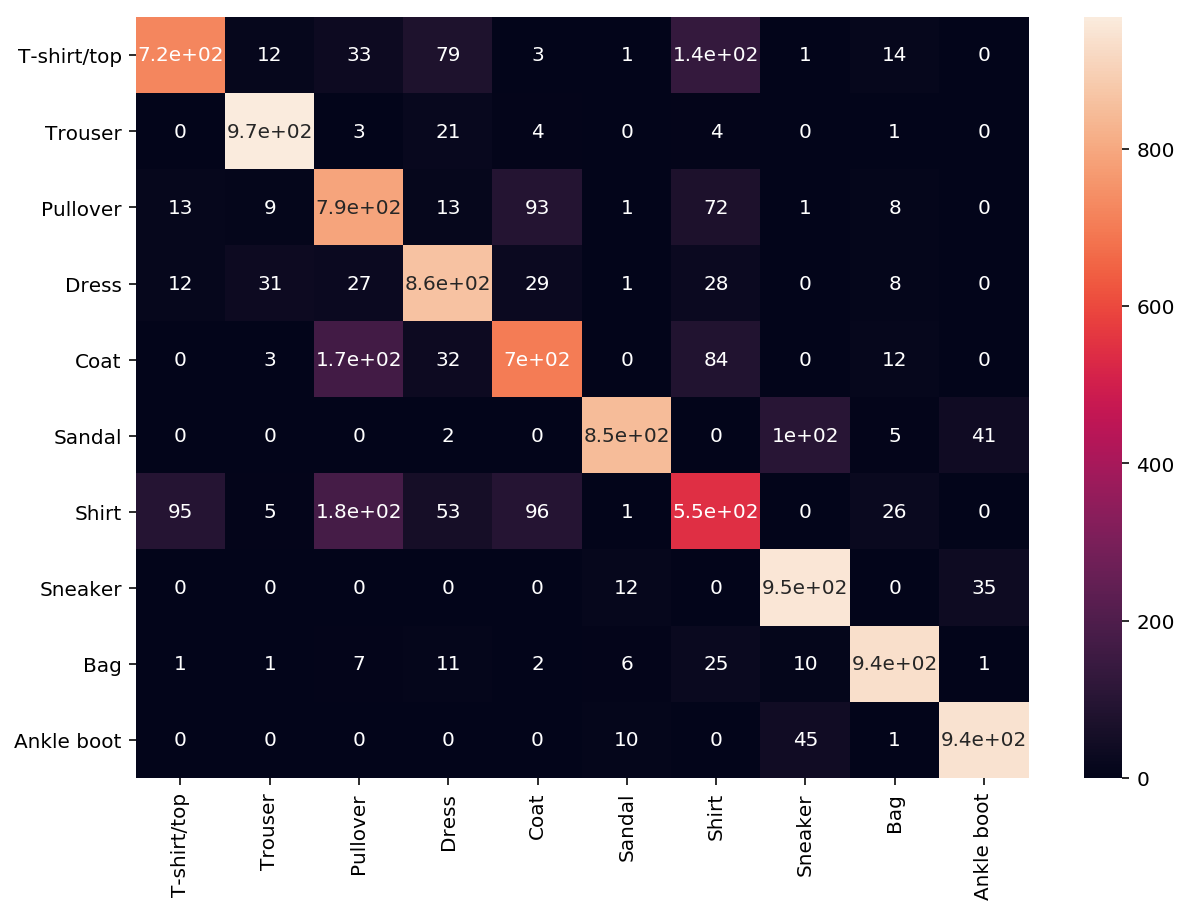

In [70]:
import pandas as pd
import seaborn as sn
df_cm = pd.DataFrame(array, index = [i for i in classes],
                  columns = [i for i in classes ])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)